In [2]:
import os
import joblib as jl
import numpy as np
import glob
import matplotlib.pyplot as plt
import json
import scipy

In [3]:
def load_jl(path):
    logs =[]
    for p in glob.glob(os.path.join(path, 'sim*')):
        jl_ode_log=jl.load(p)
        logs.append(jl_ode_log)
    args=json.load(open(os.path.join(path, 'args.json'), 'rb'))
    
    return logs, args

In [4]:
def pos_exponential_func(x,a,b,c):
    return a * np.exp(b * x) + c
def neg_exponential_func(x,a,b,c):
    return a * np.exp(-b * x) + c
def log_func(x,a,b):
    return a * np.log(-x) + b

### What is a saturation overlap for a single task?

In [169]:
saturation_dict= {}
for p in glob.glob('hrl_ode_logs/051023_single_task_saturation//*/'):
    logs, args=load_jl(p)
    if args['v_norm']==0:
        for log in logs:
            if args['seq_length'] in saturation_dict.keys():
                saturation_dict[args['seq_length']].append(np.max(log['nid']['overlap']))
            else:
                saturation_dict[args['seq_length']] = [np.max(log['nid']['overlap'])]

In [170]:

popt, pcov = scipy.optimize.curve_fit(neg_exponential_func,
                         xdata = np.concatenate([[k] * len(v) for k,v in saturation_dict.items()]),
                         ydata = np.concatenate(list(saturation_dict.values())))

In [171]:
a,b,c= popt
print(f'{a:.3f}*exp(-{b:.3f}*x) + {c:.3f}')

-0.460*exp(-0.558*x) + 0.945


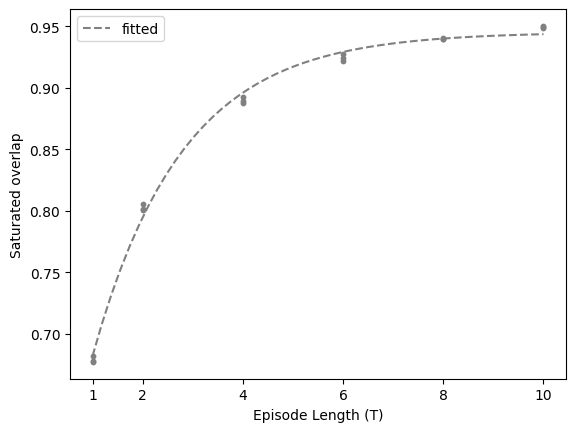

In [172]:
for i in saturation_dict.keys():
    plt.scatter([i] * len(saturation_dict[i]), saturation_dict[i], c = 'gray', s =10)

plt.plot(np.linspace(1, 10, 50), neg_exponential_func(np.linspace(1, 10, 50), *popt), c = 'gray', ls = '--', 
         label= 'fitted')
plt.xticks(list(saturation_dict.keys()), list(saturation_dict.keys()))
plt.ylabel('Saturated overlap')
plt.xlabel('Episode Length (T)')
plt.legend()

### What is a time it takes to get to a saturation threshold for a single task?

In [416]:
single_task_thr_dict = {}
#sat_thr_dict = {4: 0.86, 1: 0.64, 2: 0.78, 8:0.91, 6:0.89, 10: 0.93}
#sat_thr_dict = {4: 0.84, 1: 0.64, 2: 0.75, 8:0.88, 6:0.85, 10: 0.9}
sat_thr_dict = {1:0.64, 2: 0.77, 4: 0.87, 6:0.91, 8: 0.93, 10: 0.94}
for p in glob.glob('hrl_ode_logs/121023_curriculum_saturation/*/'):
    logs, args=load_jl(p)
    if args['v_norm']==0:
        for log in logs:
            if args['seq_length'] in single_task_thr_dict.keys():
                single_task_thr_dict[args['seq_length']].append(np.where(log['nid']['overlap']> sat_thr_dict[args['seq_length']])[0][0] * args['update_frequency'])
            else:
                single_task_thr_dict[args['seq_length']]=[np.where(log['nid']['overlap']> sat_thr_dict[args['seq_length']])[0][0]* args['update_frequency']]


In [417]:
popt, pcov = scipy.optimize.curve_fit(neg_exponential_func,
                         xdata = np.concatenate([[k] * len(v) for k,v in single_task_thr_dict.items()]),
                         ydata = np.concatenate(list(single_task_thr_dict.values())))

In [428]:
a,b,c= popt
print(f'{a:.3f}*exp({b:.3f}*x) + {c:.3f}')

32030.578*exp(-0.340*x) + -19648.186


Text(0.5, 0, 'Episode Length (T)')

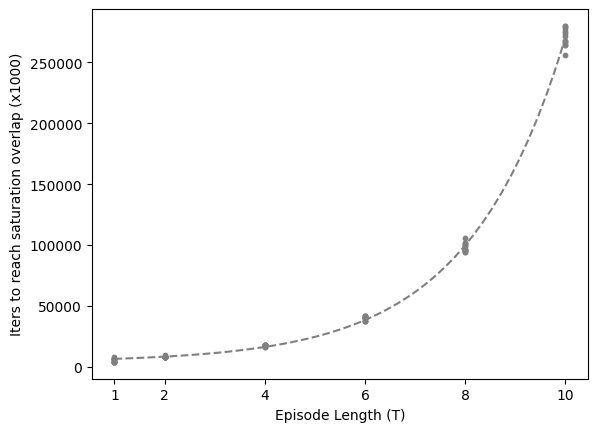

In [419]:

for i in single_task_thr_dict.keys():
    plt.scatter([i] * len(single_task_thr_dict[i]), single_task_thr_dict[i], c = 'gray', s =10)

plt.plot(np.linspace(1, 10, 50), neg_exponential_func(np.linspace(1, 10, 50), *popt), c = 'gray', ls = '--', 
         label= 'fitted')

plt.xticks(list(single_task_thr_dict.keys()), list(single_task_thr_dict.keys()))
plt.ylabel('Iters to reach saturation overlap (x1000)')
plt.xlabel('Episode Length (T)')


In [432]:
single_task_thr_dict

{1: [8000, 6000, 6000, 6000, 4000, 4000, 6000, 4000, 6000, 4000, 4000, 4000],
 6: [38000,
  40000,
  40000,
  40000,
  40000,
  42000,
  38000,
  40000,
  38000,
  42000,
  42000,
  42000],
 8: [100000,
  100000,
  106000,
  96000,
  96000,
  94000,
  94000,
  102000,
  96000,
  98000,
  102000,
  96000],
 2: [8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 10000, 8000],
 4: [18000, 16000, 18000, 18000, 18000, 16000, 18000, 18000, 18000],
 10: [264000,
  280000,
  272000,
  278000,
  280000,
  274000,
  268000,
  276000,
  264000,
  256000,
  268000,
  266000]}

### What is a time it takes to get to a threshold 0.6 for a single task?

In [195]:
def time_to_get_v(v):
    time_thr_dict = {}
    sat_thr_dict = {4: v, 1: v, 2: v, 8:v, 6:v, 10: v}

    for p in glob.glob('hrl_ode_logs/051023_single_task_saturation//*/'):
        logs, args=load_jl(p)
        if args['v_norm']==0:
            for log in logs:
                if args['seq_length'] in time_thr_dict.keys():
                    try:
                        time_thr_dict[args['seq_length']].append(np.where(log['nid']['overlap']> sat_thr_dict[args['seq_length']])[0][0])
                    except:
                        pass
                else:
                    try:
                        time_thr_dict[args['seq_length']]= [np.where(log['nid']['overlap']> sat_thr_dict[args['seq_length']])[0][0]]
                    except:
                        pass
    return time_thr_dict

Thr. 0.5: 0.499*exp(0.618*x) + 1.898
Thr. 0.6: 0.569*exp(0.609*x) + 3.025
Thr. 0.7: 0.655*exp(0.598*x) + 3.834
Thr. 0.8: 0.002*exp(1.166*x) + 58.446


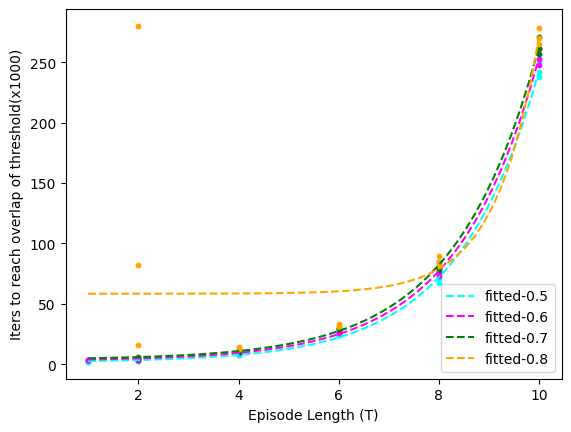

In [198]:
colors =['cyan', 'magenta', 'green', 'orange']
for n, thr in enumerate([0.5,0.6,0.7,0.8]):
    time_thr_dict = time_to_get_v(thr)
    popt, pcov = scipy.optimize.curve_fit(pos_exponential_func,
                         xdata = np.concatenate([[k] * len(v) for k,v in time_thr_dict.items()]),
                         ydata = np.concatenate(list(time_thr_dict.values())))
    a,b,c= popt
    
    print(f'Thr. {thr}: {a:.3f}*exp({b:.3f}*x) + {c:.3f}')
    
    for i in time_thr_dict.keys():
        plt.scatter([i] * len(time_thr_dict[i]), time_thr_dict[i], c = colors[n], s =10)

    plt.plot(np.linspace(1, 10, 50), pos_exponential_func(np.linspace(1, 10, 50), *popt), 
             c = colors[n], ls = '--', 
             label= f'fitted-{thr}')

    plt.xticks(list(time_thr_dict.keys()), list(time_thr_dict.keys()))
    plt.ylabel(f'Iters to reach overlap of threshold(x1000)')
    plt.xlabel('Episode Length (T)')
    plt.legend()

### Composite task - baseline

In [40]:
def baseline_composite_task_saturation(logpath, k):
    task_sat_dict = {}
    for p in glob.glob(f'{logpath}/*/'):
        logs, args=load_jl(p)
        if args['v_norm']==0 and args['num_tasks']==k:
            for log in logs:
                if args['seq_length'] in task_sat_dict.keys():
                    try:
                        task_sat_dict[args['seq_length']].append(np.max(log['nid']['overlap_tilde']))
                    except:
                        pass
                else:
                    try:
                        task_sat_dict[args['seq_length']]= [np.max(log['nid']['overlap_tilde'])]
                    except:
                        pass
    return task_sat_dict

def composite_task_saturation_time(logpath, k, after_pretraining=False):
    sat_thr_dict={1:0.64, 2: 0.78, 4: 0.87, 6:0.91, 8: 0.93, 10: 0.94}
    time_sat_dict = {}
    for p in glob.glob(f'{logpath}/*/'):
        logs, args=load_jl(p)
        if args['v_norm']==0 and args['num_tasks']==k:
            if after_pretraining:
                starting_point=args['nums_iter'][0]
            else:
                starting_point = 0
            for log in logs:
                if args['seq_length'] in time_sat_dict.keys():
                    try:
                        time_sat_dict[args['seq_length']].append(
                            np.where(log['nid']['overlap_tilde']>sat_thr_dict[args['seq_length']])[0][0] * args['update_frequency'] - starting_point)
                    except:
                        pass
                else:
                    try:
                        time_sat_dict[args['seq_length']]= [np.where(log['nid']['overlap_tilde']>sat_thr_dict[args['seq_length']])[0][0]* args['update_frequency'] -starting_point]
                    except:
                        pass
    return sat_thr_dict, time_sat_dict

ValueError: need at least one array to concatenate

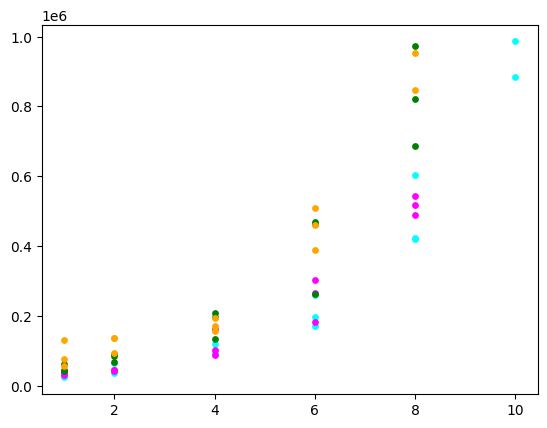

In [36]:
logpath = 'hrl_ode_logs/121023_baseline_saturation/'
fig = plt.figure()
colors =['cyan', 'magenta', 'green', 'orange']
for n,k in enumerate([2,4,6,8,10]):
    sat_thr_dict, composite_sat_dict=composite_task_saturation_time(logpath, k)
    plt.scatter(np.concatenate([[i]*len(composite_sat_dict[i]) for i in composite_sat_dict.keys()]),
               np.concatenate(list(composite_sat_dict.values())), s=15, c = colors[n], label = k)
    """
    try:
    
        popt, pcov = scipy.optimize.curve_fit(neg_exponential_func,
                         xdata = np.concatenate([[k] * len(v) for k,v in composite_sat_dict.items()]),
                         ydata = np.concatenate(list(composite_sat_dict.values())))
        a,b,c= popt
        
        print(f'{a:.3f}*exp({b:.3f}*x) + {c:.3f}')

        plt.plot(np.linspace(1, 10, 50), neg_exponential_func(np.linspace(1, 10, 50), *popt), 
                 c = colors[n], ls = '--')
    except:
        pass
    """
plt.title ('Baseline')
plt.legend(title = '# Task')
plt.xlabel('Episode length(T)')
plt.ylabel('# Iters to achieve threshold overlap')

In [20]:
composite_sat_dict.keys()

dict_keys([6, 1, 2, 4, 8, 10])

24000
20000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


20000
18000


Text(0, 0.5, '# Iters to achieve threshold overlap')

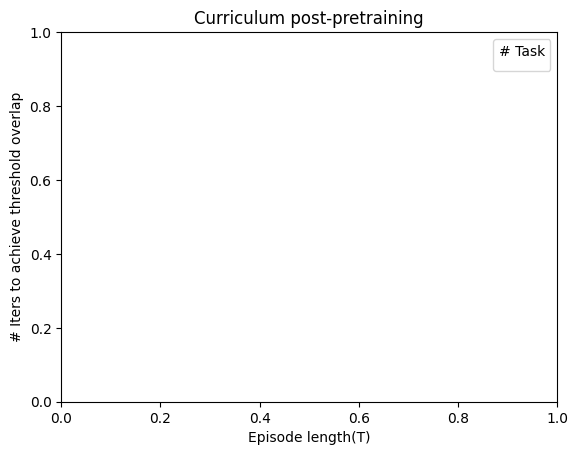

In [45]:
logpath = 'hrl_ode_logs/121023_curriculum_saturation/'
fig = plt.figure()
colors =['cyan', 'magenta', 'green', 'orange']
t=6
for n,k in enumerate([2,4,6,8]):
    sat_thr_dict_post, composite_sat_dict_post=composite_task_saturation_time(logpath, k, True)
    sat_thr_dict, composite_sat_dict=composite_task_saturation_time(logpath, k, False)
    
    for t in [6]:
        try:
            post_training_time = composite_sat_dict_post[t]
            pre_training_time = composite_sat_dict[t]

            print(np.max(post_training_time))

        except:
            print('no t')
    
    """
    for i in [2,4,6,8,10]:
        try:
            l=plt.scatter([i]*len(composite_sat_dict[i]),
                       composite_sat_dict[i], s=15, c = colors[n], label = k)
        except:
            pass
    
    try:
    
        popt, pcov = scipy.optimize.curve_fit(neg_exponential_func,
                         xdata = np.concatenate([[k] * len(v) for k,v in composite_sat_dict.items()]),
                         ydata = np.concatenate(list(composite_sat_dict.values())))
        a,b,c= popt
        
        print(f'{a:.3f}*exp({b:.3f}*x) + {c:.3f}')

        plt.plot(np.linspace(1, 10, 50), neg_exponential_func(np.linspace(1, 10, 50), *popt), 
                 c = colors[n], ls = '--')
    except:
        pass
    """
plt.title ('Curriculum post-pretraining')
plt.legend(title = '# Task')
plt.xlabel('Episode length(T)')
plt.ylabel('# Iters to achieve threshold overlap')

In [457]:
pretraining_time

array([ 241000.        ,  241000.        ,  241000.        ,
         31000.        ,   31000.        ,   31000.        ,
         49000.        ,   49000.        ,   49000.        ,
        105333.33333333,  105333.33333333,  105333.33333333,
        590000.        ,  590000.        ,  590000.        ,
       1623000.        , 1623000.        , 1623000.        ])

K=2: 4535.534*exp(-0.481*x) + 11952.432
K=4: 7397.911*exp(-0.499*x) + 21348.658
K=6: 10563.086*exp(-0.504*x) + 30839.897
K=8: 13593.406*exp(-0.507*x) + 39580.383


"\nlogpath = 'hrl_ode_logs/121023_baseline_saturation/'\ncolors =['cyan', 'magenta', 'green', 'orange']\nfor n,k in enumerate([2]):\n    sat_thr_dict, composite_sat_dict=composite_task_saturation_time(logpath, k)\n    plt.scatter(np.concatenate([[i]*len(composite_sat_dict[i]) for i in composite_sat_dict.keys()]),\n               np.concatenate(list(composite_sat_dict.values())), s=15, c = colors[n], label = k)\n    try:\n    \n        popt, pcov = scipy.optimize.curve_fit(neg_exponential_func,\n                         xdata = np.concatenate([[k] * len(v) for k,v in composite_sat_dict.items()]),\n                         ydata = np.concatenate(list(composite_sat_dict.values())))\n        a,b,c= popt\n        \n        print(f'{a:.3f}*exp({b:.3f}*x) + {c:.3f}')\n\n        #plt.plot(np.linspace(1, 10, 50), neg_exponential_func(np.linspace(1, 10, 50), *popt), c = colors[n])\n    except:\n        pass\n"

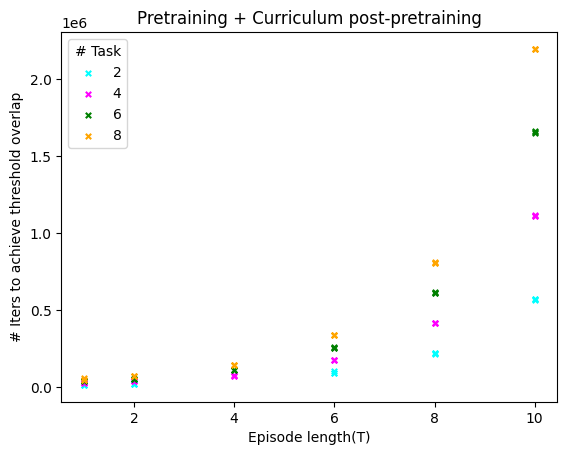

In [461]:
logpath = 'hrl_ode_logs/121023_curriculum_saturation/'
fig = plt.figure()
colors =['cyan', 'magenta', 'green', 'orange']
for n,k in enumerate([2,4,6,8]):
    sat_thr_dict, composite_sat_dict=composite_task_saturation_time(logpath, k, True)
    pretraining_time = np.concatenate([[np.mean(single_task_thr_dict[i])*k] *len(composite_sat_dict[i]) for i in composite_sat_dict.keys()])
    total_time = np.concatenate(list(composite_sat_dict.values())) + pretraining_time
    plt.scatter(np.concatenate([[i]*len(composite_sat_dict[i]) for i in composite_sat_dict.keys()]),
               total_time  , s=15, c = colors[n], label = k, marker = 'x')
    try:
    
        popt, pcov = scipy.optimize.curve_fit(neg_exponential_func,
                         xdata = np.concatenate([[k] * len(v) for k,v in composite_sat_dict.items()]),
                         ydata = total_time)
        a,b,c= popt
        
        print(f'K={k}: {a:.3f}*exp({b:.3f}*x) + {c:.3f}')

        #plt.plot(np.linspace(1, 10, 50), neg_exponential_func(np.linspace(1, 10, 50), *popt), 
        #         c = colors[n], ls = '--')
    except:
        pass
plt.title ('Pretraining + Curriculum post-pretraining')
plt.legend(title = '# Task')
plt.xlabel('Episode length(T)')
plt.ylabel('# Iters to achieve threshold overlap')
"""
logpath = 'hrl_ode_logs/121023_baseline_saturation/'
colors =['cyan', 'magenta', 'green', 'orange']
for n,k in enumerate([2]):
    sat_thr_dict, composite_sat_dict=composite_task_saturation_time(logpath, k)
    plt.scatter(np.concatenate([[i]*len(composite_sat_dict[i]) for i in composite_sat_dict.keys()]),
               np.concatenate(list(composite_sat_dict.values())), s=15, c = colors[n], label = k)
    try:
    
        popt, pcov = scipy.optimize.curve_fit(neg_exponential_func,
                         xdata = np.concatenate([[k] * len(v) for k,v in composite_sat_dict.items()]),
                         ydata = np.concatenate(list(composite_sat_dict.values())))
        a,b,c= popt
        
        print(f'{a:.3f}*exp({b:.3f}*x) + {c:.3f}')

        #plt.plot(np.linspace(1, 10, 50), neg_exponential_func(np.linspace(1, 10, 50), *popt), c = colors[n])
    except:
        pass
"""

28788.097*exp(-0.365*x) + -14248.307


/tmp/ipykernel_2364385/3660551289.py:4: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


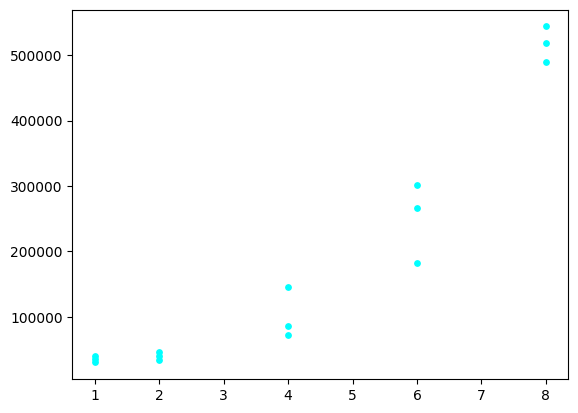

In [464]:

logpath = 'hrl_ode_logs/121023_baseline_saturation/'
colors =['cyan', 'magenta', 'green', 'orange']
for n,k in enumerate([4]):
    sat_thr_dict, composite_sat_dict=composite_task_saturation_time(logpath, k)
    plt.scatter(np.concatenate([[i]*len(composite_sat_dict[i]) for i in composite_sat_dict.keys()]),
               np.concatenate(list(composite_sat_dict.values())), s=15, c = colors[n], label = k)
    try:
    
        popt, pcov = scipy.optimize.curve_fit(neg_exponential_func,
                         xdata = np.concatenate([[k] * len(v) for k,v in composite_sat_dict.items()]),
                         ydata = np.concatenate(list(composite_sat_dict.values())))
        a,b,c= popt
        
        print(f'{a:.3f}*exp({b:.3f}*x) + {c:.3f}')

        #plt.plot(np.linspace(1, 10, 50), neg_exponential_func(np.linspace(1, 10, 50), *popt), c = colors[n])
    except:
        pass
